# 1.24b: Phase Transitions in Token Dynamics

**Question:** When do tokens transition from continuous motion → lattice hopping → frozen?

## The Cooling Sequence

All tokens start in **classical motion** (continuous, smooth). As gradients decay, each token passes through two phase transitions:

### Phase 1: Classical Motion (GIVEN at start)
- Displacement > √D × ULP (where D = hidden dimension = 64)
- Token can move in arbitrary directions
- Quantization irrelevant - gradient updates are large enough to move freely
- For D=64: displacement > 8×ULP

### Transition 1: Classical → Quantum (t_quantum)
- Displacement drops below √D × ULP
- Enters lattice-hopping regime
- Can no longer move in arbitrary directions - constrained to lattice geometry

### Phase 2: Quantum Motion  
- ULP < displacement ≤ √D × ULP
- Discrete jumps on bfloat16 lattice
- Gradients accumulate until they exceed 1 ULP, then hop
- Motion is intermittent and directionally constrained

### Transition 2: Quantum → Frozen (t_frozen)
- Displacement becomes exactly zero
- Complete cessation of motion

### Phase 3: Frozen
- Displacement = 0 (exactly, in bfloat16)
- Gradients too small to accumulate to 1 ULP

## Analysis

For each token, find:
- **t_quantum**: First timestep where displacement < √D×ULP (and stays there)
- **t_frozen**: First timestep where displacement = 0 (and stays zero)
- **Duration in quantum phase**: t_frozen - t_quantum

Compare dead vs. live token transition timing.

## Parameters

In [1]:
DATA_PATH = "../tensors/Flannel/1.20h_flannel_7.safetensors"
TOKEN_MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Phase boundaries
HIDDEN_DIM = 64
CLASSICAL_THRESHOLD = HIDDEN_DIM ** 0.5  # √D ULP - diagonal lattice hop threshold

# Transition detection: require N consecutive steps in new phase
CONSECUTIVE_THRESHOLD = 10

RANDOM_SEED = 42

print(f"✓ Parameters set")
print(f"  Classical threshold: √{HIDDEN_DIM} = {CLASSICAL_THRESHOLD:.3f} × ULP")

✓ Parameters set
  Classical threshold: √64 = 8.000 × ULP


## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from tqdm import tqdm

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading Flannel 7 data...")
data = load_file(DATA_PATH)

# Keep bfloat16 for exact zero detection
W_bf16 = data['W'][0].to(device)
W = W_bf16.to(torch.float32)

n_steps = W.shape[0] - 1
vocab_size = W.shape[1]
hidden_dim = W.shape[2]

print(f"  W shape: {tuple(W.shape)}")
print(f"  Steps: {n_steps}")
print(f"  Vocabulary: {vocab_size:,}")

Loading Flannel 7 data...
  W shape: (501, 10000, 64)
  Steps: 500
  Vocabulary: 10,000


In [5]:
print("\nLoading token masks...")
mask_data = load_file(TOKEN_MASK_PATH)
dead_mask = mask_data['dead_mask'].to(device)
live_mask = mask_data['live_mask'].to(device)

dead_indices = torch.where(dead_mask)[0]
live_indices = torch.where(live_mask)[0]

n_dead = len(dead_indices)
n_live = len(live_indices)

print(f"  Dead tokens: {n_dead:,}")
print(f"  Live tokens: {n_live:,}")


Loading token masks...
  Dead tokens: 3,699
  Live tokens: 6,301


## Compute ULP and Displacements

In [6]:
def compute_ulp_size(values):
    """Compute ULP for bfloat16 values."""
    abs_values = values.abs()
    abs_values = torch.where(abs_values > 0, abs_values, torch.tensor(1e-45, device=values.device))
    exponent = torch.floor(torch.log2(abs_values))
    ulp = torch.pow(2.0, exponent - 7)
    return ulp

print("Computing displacements and ULP thresholds...\n")

displacements = torch.zeros(n_steps, vocab_size, device=device)
ulp_thresholds = torch.zeros(n_steps, vocab_size, device=device)
is_zero = torch.zeros(n_steps, vocab_size, dtype=torch.bool, device=device)

for t in tqdm(range(n_steps), desc="Processing"):
    # Displacement (L2 norm)
    delta = W[t+1] - W[t]
    displacements[t] = torch.norm(delta, dim=1)
    
    # Exact zero check in bfloat16
    delta_bf16 = W_bf16[t+1] - W_bf16[t]
    is_zero[t] = (delta_bf16 == 0).all(dim=1)
    
    # ULP at current position
    position_magnitude = torch.norm(W[t], dim=1)
    ulp_thresholds[t] = compute_ulp_size(position_magnitude)

print(f"\n✓ Computed displacements")

Computing displacements and ULP thresholds...



Processing: 100%|██████████| 500/500 [00:00<00:00, 1344.57it/s]


✓ Computed displacements


## Find Phase Transitions for Each Token

In [7]:
print("\nFinding phase transitions...\n")

# Compute displacement/ULP ratio
ratio = displacements / ulp_thresholds

# Classify phases at each timestep
in_quantum = ratio < CLASSICAL_THRESHOLD  # Entered quantum regime (< 10×ULP)
in_frozen = is_zero  # Frozen (exactly zero displacement)

# Vectorized transition detection
def find_first_sustained(state_matrix, threshold):
    """
    Find first timestep where each token enters and stays in a state.
    
    Args:
        state_matrix: (n_steps, vocab_size) boolean tensor
        threshold: number of consecutive True values required
    
    Returns:
        (vocab_size,) tensor with first sustained timestep (-1 if never)
    """
    n_steps, vocab_size = state_matrix.shape
    result = torch.full((vocab_size,), -1, dtype=torch.long, device=state_matrix.device)
    
    # For each possible starting timestep
    for t in range(n_steps - threshold + 1):
        # Check if next THRESHOLD steps are all True
        window = state_matrix[t:t+threshold, :]  # (threshold, vocab_size)
        sustained = window.all(dim=0)  # (vocab_size,) - True if all threshold steps are True
        
        # For tokens that haven't transitioned yet and are sustained at this t
        needs_update = (result == -1) & sustained
        result[needs_update] = t
    
    return result

print("Finding quantum transitions...")
t_quantum = find_first_sustained(in_quantum, CONSECUTIVE_THRESHOLD)

print("Finding freeze transitions...")
t_frozen = find_first_sustained(in_frozen, CONSECUTIVE_THRESHOLD)

print(f"\n✓ Phase transitions identified")


Finding phase transitions...

Finding quantum transitions...
Finding freeze transitions...

✓ Phase transitions identified


## Statistics: Dead Tokens

In [8]:
print(f"\n{'='*60}")
print(f"DEAD TOKEN PHASE TRANSITIONS")
print(f"{'='*60}\n")

t_quantum_dead = t_quantum[dead_indices].cpu().numpy()
t_frozen_dead = t_frozen[dead_indices].cpu().numpy()

# Filter out tokens that never transitioned
entered_quantum = t_quantum_dead >= 0
entered_frozen = t_frozen_dead >= 0

n_quantum = entered_quantum.sum()
n_frozen = entered_frozen.sum()

print(f"Total dead tokens: {n_dead:,}")
print(f"  Entered quantum phase: {n_quantum:,} ({100*n_quantum/n_dead:.1f}%)")
print(f"  Reached frozen state: {n_frozen:,} ({100*n_frozen/n_dead:.1f}%)")
print()

if n_quantum > 0:
    t_q = t_quantum_dead[entered_quantum]
    print(f"Classical → Quantum transition:")
    print(f"  Earliest: t={t_q.min()}")
    print(f"  Median:   t={int(np.median(t_q))}")
    print(f"  Latest:   t={t_q.max()}")
    print()

if n_frozen > 0:
    t_f = t_frozen_dead[entered_frozen]
    print(f"Quantum → Frozen transition:")
    print(f"  Earliest: t={t_f.min()}")
    print(f"  Median:   t={int(np.median(t_f))}")
    print(f"  Latest:   t={t_f.max()}")
    print()

# Duration in quantum phase
if n_quantum > 0 and n_frozen > 0:
    both = entered_quantum & entered_frozen
    if both.sum() > 0:
        quantum_duration = t_frozen_dead[both] - t_quantum_dead[both]
        print(f"Time spent in quantum phase:")
        print(f"  Minimum:  {quantum_duration.min()} steps")
        print(f"  Median:   {int(np.median(quantum_duration))} steps")
        print(f"  Maximum:  {quantum_duration.max()} steps")

print(f"\n{'='*60}")


DEAD TOKEN PHASE TRANSITIONS

Total dead tokens: 3,699
  Entered quantum phase: 3,699 (100.0%)
  Reached frozen state: 3,660 (98.9%)

Classical → Quantum transition:
  Earliest: t=0
  Median:   t=1
  Latest:   t=14

Quantum → Frozen transition:
  Earliest: t=184
  Median:   t=296
  Latest:   t=490

Time spent in quantum phase:
  Minimum:  183 steps
  Median:   295 steps
  Maximum:  489 steps



## Statistics: Live Tokens

In [9]:
print(f"\n{'='*60}")
print(f"LIVE TOKEN PHASE TRANSITIONS")
print(f"{'='*60}\n")

t_quantum_live = t_quantum[live_indices].cpu().numpy()
t_frozen_live = t_frozen[live_indices].cpu().numpy()

entered_quantum_live = t_quantum_live >= 0
entered_frozen_live = t_frozen_live >= 0

n_quantum_live = entered_quantum_live.sum()
n_frozen_live = entered_frozen_live.sum()

print(f"Total live tokens: {n_live:,}")
print(f"  Entered quantum phase: {n_quantum_live:,} ({100*n_quantum_live/n_live:.1f}%)")
print(f"  Reached frozen state: {n_frozen_live:,} ({100*n_frozen_live/n_live:.1f}%)")
print()

if n_quantum_live > 0:
    t_q = t_quantum_live[entered_quantum_live]
    print(f"Classical → Quantum transition:")
    print(f"  Earliest: t={t_q.min()}")
    print(f"  Median:   t={int(np.median(t_q))}")
    print(f"  Latest:   t={t_q.max()}")
    print()

if n_frozen_live > 0:
    t_f = t_frozen_live[entered_frozen_live]
    print(f"Quantum → Frozen transition:")
    print(f"  Earliest: t={t_f.min()}")
    print(f"  Median:   t={int(np.median(t_f))}")
    print(f"  Latest:   t={t_f.max()}")
    print()

# Duration in quantum phase
if n_quantum_live > 0 and n_frozen_live > 0:
    both = entered_quantum_live & entered_frozen_live
    if both.sum() > 0:
        quantum_duration = t_frozen_live[both] - t_quantum_live[both]
        print(f"Time spent in quantum phase:")
        print(f"  Minimum:  {quantum_duration.min()} steps")
        print(f"  Median:   {int(np.median(quantum_duration))} steps")
        print(f"  Maximum:  {quantum_duration.max()} steps")

print(f"\n{'='*60}")


LIVE TOKEN PHASE TRANSITIONS

Total live tokens: 6,301
  Entered quantum phase: 6,301 (100.0%)
  Reached frozen state: 1,509 (23.9%)

Classical → Quantum transition:
  Earliest: t=0
  Median:   t=1
  Latest:   t=19

Quantum → Frozen transition:
  Earliest: t=80
  Median:   t=481
  Latest:   t=490

Time spent in quantum phase:
  Minimum:  79 steps
  Median:   480 steps
  Maximum:  489 steps



## Plot: Transition Time Distributions

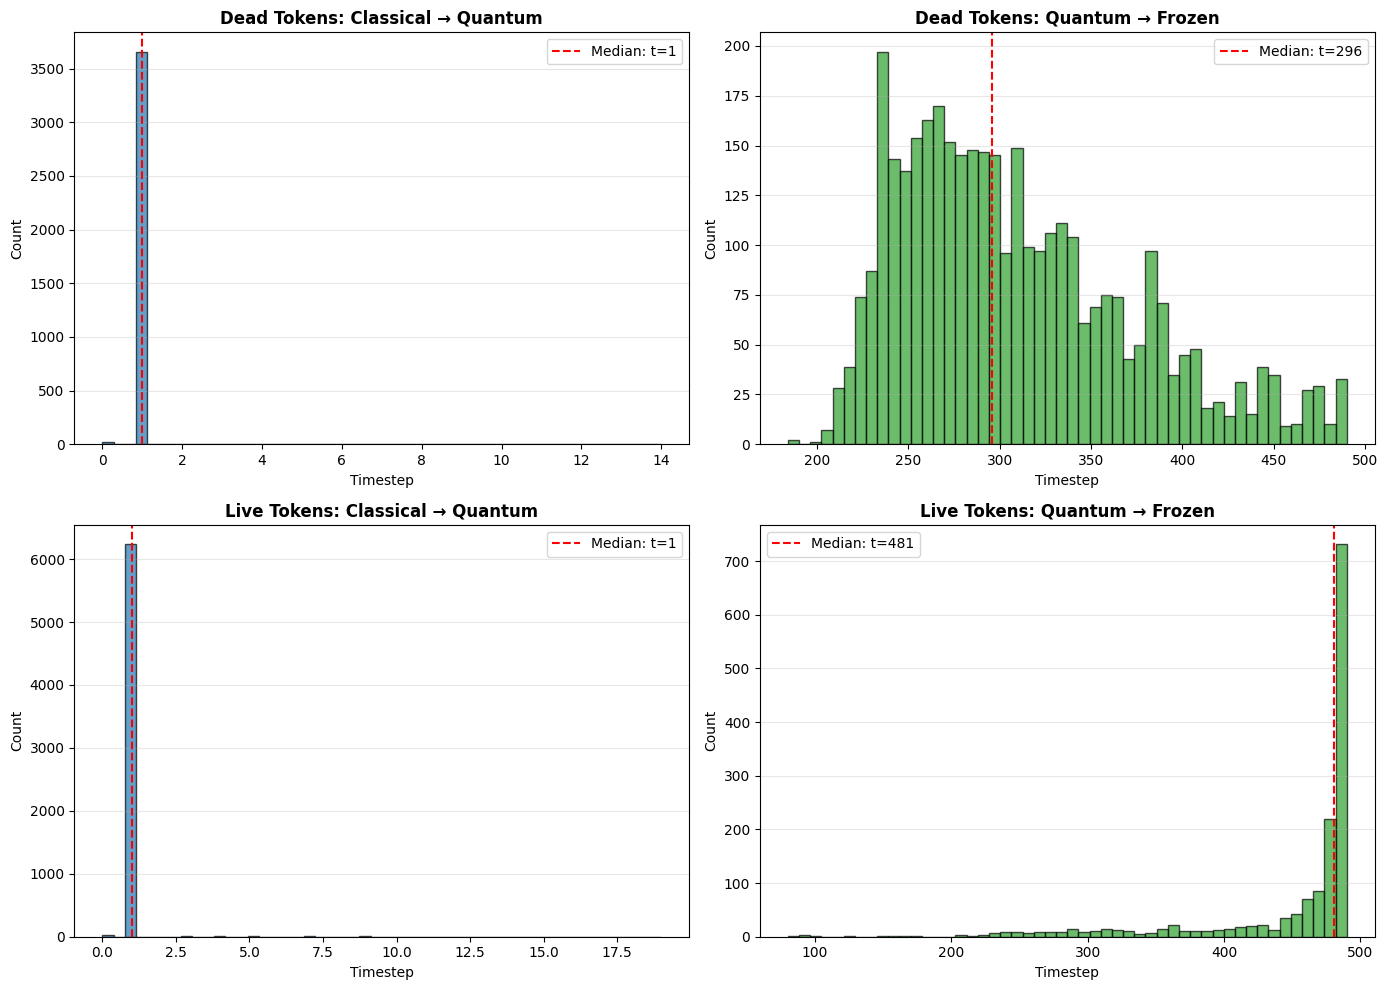

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

# Dead: Classical → Quantum
if n_quantum > 0:
    axes[0, 0].hist(t_quantum_dead[entered_quantum], bins=50, color='C0', alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(np.median(t_quantum_dead[entered_quantum]), color='red', linestyle='--', 
                       label=f'Median: t={int(np.median(t_quantum_dead[entered_quantum]))}')
    axes[0, 0].set_title('Dead Tokens: Classical → Quantum', fontweight='bold')
    axes[0, 0].set_xlabel('Timestep')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')

# Dead: Quantum → Frozen
if n_frozen > 0:
    axes[0, 1].hist(t_frozen_dead[entered_frozen], bins=50, color='C2', alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(np.median(t_frozen_dead[entered_frozen]), color='red', linestyle='--',
                       label=f'Median: t={int(np.median(t_frozen_dead[entered_frozen]))}')
    axes[0, 1].set_title('Dead Tokens: Quantum → Frozen', fontweight='bold')
    axes[0, 1].set_xlabel('Timestep')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')

# Live: Classical → Quantum
if n_quantum_live > 0:
    axes[1, 0].hist(t_quantum_live[entered_quantum_live], bins=50, color='C0', alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(np.median(t_quantum_live[entered_quantum_live]), color='red', linestyle='--',
                       label=f'Median: t={int(np.median(t_quantum_live[entered_quantum_live]))}')
    axes[1, 0].set_title('Live Tokens: Classical → Quantum', fontweight='bold')
    axes[1, 0].set_xlabel('Timestep')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')

# Live: Quantum → Frozen
if n_frozen_live > 0:
    axes[1, 1].hist(t_frozen_live[entered_frozen_live], bins=50, color='C2', alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(np.median(t_frozen_live[entered_frozen_live]), color='red', linestyle='--',
                       label=f'Median: t={int(np.median(t_frozen_live[entered_frozen_live]))}')
    axes[1, 1].set_title('Live Tokens: Quantum → Frozen', fontweight='bold')
    axes[1, 1].set_xlabel('Timestep')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Plot: Quantum Phase Duration

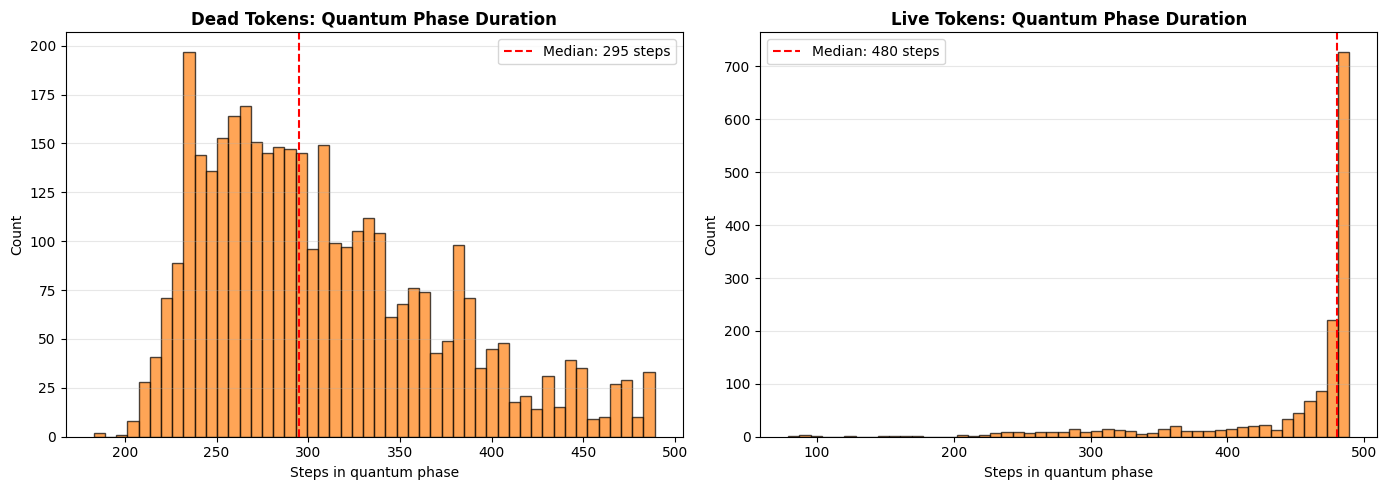

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Dead tokens
both_dead = entered_quantum & entered_frozen
if both_dead.sum() > 0:
    duration_dead = t_frozen_dead[both_dead] - t_quantum_dead[both_dead]
    ax1.hist(duration_dead, bins=50, color='C1', alpha=0.7, edgecolor='black')
    ax1.axvline(np.median(duration_dead), color='red', linestyle='--',
                label=f'Median: {int(np.median(duration_dead))} steps')
    ax1.set_title('Dead Tokens: Quantum Phase Duration', fontweight='bold')
    ax1.set_xlabel('Steps in quantum phase')
    ax1.set_ylabel('Count')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

# Live tokens
both_live = entered_quantum_live & entered_frozen_live
if both_live.sum() > 0:
    duration_live = t_frozen_live[both_live] - t_quantum_live[both_live]
    ax2.hist(duration_live, bins=50, color='C1', alpha=0.7, edgecolor='black')
    ax2.axvline(np.median(duration_live), color='red', linestyle='--',
                label=f'Median: {int(np.median(duration_live))} steps')
    ax2.set_title('Live Tokens: Quantum Phase Duration', fontweight='bold')
    ax2.set_xlabel('Steps in quantum phase')
    ax2.set_ylabel('Count')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Plot: Phase Occupancy Over Time

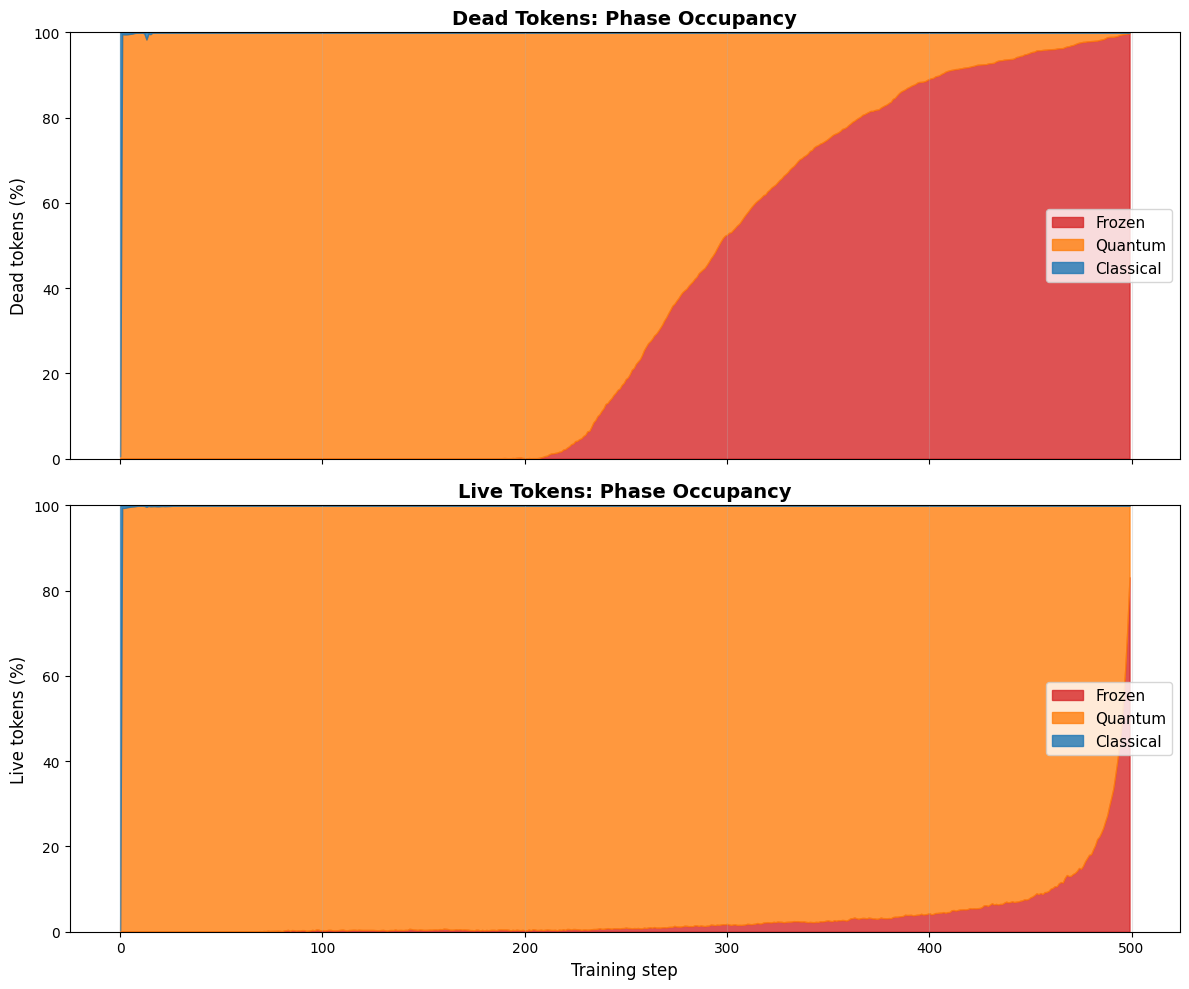

In [12]:
# Compute what fraction of tokens are in each phase at each timestep
in_classical = ratio >= CLASSICAL_THRESHOLD

# Dead tokens
classical_dead = in_classical[:, dead_indices].float().mean(dim=1).cpu().numpy()
quantum_dead = (in_quantum[:, dead_indices] & ~is_zero[:, dead_indices]).float().mean(dim=1).cpu().numpy()
frozen_dead = is_zero[:, dead_indices].float().mean(dim=1).cpu().numpy()

# Live tokens
classical_live = in_classical[:, live_indices].float().mean(dim=1).cpu().numpy()
quantum_live = (in_quantum[:, live_indices] & ~is_zero[:, live_indices]).float().mean(dim=1).cpu().numpy()
frozen_live = is_zero[:, live_indices].float().mean(dim=1).cpu().numpy()

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=100, sharex=True)

timesteps = np.arange(n_steps)

# Dead tokens (stacked)
ax1.fill_between(timesteps, 0, 100*frozen_dead, label='Frozen', color='#d62728', alpha=0.8)
ax1.fill_between(timesteps, 100*frozen_dead, 100*(frozen_dead + quantum_dead), 
                 label='Quantum', color='#ff7f0e', alpha=0.8)
ax1.fill_between(timesteps, 100*(frozen_dead + quantum_dead), 100, 
                 label='Classical', color='#1f77b4', alpha=0.8)

ax1.set_ylabel('Dead tokens (%)', fontsize=12)
ax1.set_title('Dead Tokens: Phase Occupancy', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='right')
ax1.grid(True, alpha=0.3, axis='x')
ax1.set_ylim(0, 100)

# Live tokens (stacked)
ax2.fill_between(timesteps, 0, 100*frozen_live, label='Frozen', color='#d62728', alpha=0.8)
ax2.fill_between(timesteps, 100*frozen_live, 100*(frozen_live + quantum_live),
                 label='Quantum', color='#ff7f0e', alpha=0.8)
ax2.fill_between(timesteps, 100*(frozen_live + quantum_live), 100,
                 label='Classical', color='#1f77b4', alpha=0.8)

ax2.set_xlabel('Training step', fontsize=12)
ax2.set_ylabel('Live tokens (%)', fontsize=12)
ax2.set_title('Live Tokens: Phase Occupancy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='right')
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

## Summary

In [13]:
print(f"\n{'='*60}")
print(f"PHASE TRANSITION SUMMARY")
print(f"{'='*60}\n")

print(f"Phase definitions:")
print(f"  Classical: displacement > √D×ULP = {CLASSICAL_THRESHOLD:.3f}×ULP (D={HIDDEN_DIM})")
print(f"  Quantum:   ULP < displacement ≤ √D×ULP")
print(f"  Frozen:    displacement = 0 (exactly, in bfloat16)")
print()
print(f"Physical basis: √D×ULP is the diagonal lattice hop distance.")
print(f"Tokens can move freely only when displacement exceeds this threshold.")
print()

print(f"Dead tokens ({n_dead:,} total):")
if n_quantum > 0:
    print(f"  Classical→Quantum: median t={int(np.median(t_quantum_dead[entered_quantum]))}")
if n_frozen > 0:
    print(f"  Quantum→Frozen: median t={int(np.median(t_frozen_dead[entered_frozen]))}")
if both_dead.sum() > 0:
    print(f"  Quantum phase duration: median {int(np.median(duration_dead))} steps")
print()

print(f"Live tokens ({n_live:,} total):")
if n_quantum_live > 0:
    print(f"  Classical→Quantum: median t={int(np.median(t_quantum_live[entered_quantum_live]))}")
if n_frozen_live > 0:
    print(f"  Quantum→Frozen: median t={int(np.median(t_frozen_live[entered_frozen_live]))}")
if both_live.sum() > 0:
    print(f"  Quantum phase duration: median {int(np.median(duration_live))} steps")

print(f"\n{'='*60}")


PHASE TRANSITION SUMMARY

Phase definitions:
  Classical: displacement > √D×ULP = 8.000×ULP (D=64)
  Quantum:   ULP < displacement ≤ √D×ULP
  Frozen:    displacement = 0 (exactly, in bfloat16)

Physical basis: √D×ULP is the diagonal lattice hop distance.
Tokens can move freely only when displacement exceeds this threshold.

Dead tokens (3,699 total):
  Classical→Quantum: median t=1
  Quantum→Frozen: median t=296
  Quantum phase duration: median 295 steps

Live tokens (6,301 total):
  Classical→Quantum: median t=1
  Quantum→Frozen: median t=481
  Quantum phase duration: median 480 steps

